# 0. Imports & methods

In [57]:
import datetime

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

import seaborn as sns

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

#from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor, Pool

#import shap
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

import dill

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

In [4]:
def show_plt(xdata, ydata, xlab, ylab, fntsize, fgsize, rot, ttl):
    plt.figure(figsize=fgsize)
    sns.barplot(x=xdata, y=ydata)
    plt.title(ttl)
    plt.ylabel(ylab, fontsize=fntsize)
    plt.xlabel(xlab, fontsize=fntsize)
    plt.xticks(rotation=rot)
    plt.show()

In [5]:
# Source: https://www.kaggle.com/vikassingh1996/don-t-underestimate-the-power-of-a-logistic-reg

def description(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['PercMissing'] = df.isnull().sum().values / df.isnull().count().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary
print('**Variable Description of  train Data:**')

**Variable Description of  train Data:**


In [6]:
# Source: https://www.kaggle.com/vikassingh1996/don-t-underestimate-the-power-of-a-logistic-reg

def replace_nan(data):
    for column in data.columns:
        if data[column].isna().sum() > 0:
            data[column] = data[column].fillna(data[column].mode()[0])


In [54]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

# 1. Read data

In [7]:
df = pd.read_csv('repp_train.csv')

In [8]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [9]:
df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [10]:
X = df.drop('Price', axis=1)
y = df['Price']

X_test = pd.read_csv('repp_test.csv')

preds_test = pd.DataFrame()
preds_test['Id'] = X_test['Id'].copy()

X.set_index('Id', inplace=True)
X_test.set_index('Id', inplace=True)

In [11]:
X.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B
12915,59,3.0,80.384476,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B
14549,154,2.0,62.254112,37.160378,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B
11993,74,2.0,80.312927,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5172,1,2.0,64.511436,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B


In [12]:
description(X)

Dataset Shape: (10000, 18)


,Name,dtypes,Missing,PercMissing,Uniques,First Value,Second Value,Third Value
0,DistrictId,int16,0,0.0000,205,35,41,53
1,Rooms,float32,0,0.0000,9,2,3,2
2,Square,float32,0,0.0000,9995,47.9816,65.6836,44.948
3,LifeSquare,float32,2113,0.2113,7886,29.4428,40.0495,29.1976
4,KitchenSquare,float32,0,0.0000,58,6,8,0
5,Floor,int8,0,0.0000,33,7,7,8
6,HouseFloor,float32,0,0.0000,44,9,9,12
7,HouseYear,int32,0,0.0000,97,1969,1978,1968
8,Ecology_1,float32,0,0.0000,129,0.0890397,6.99893e-05,0.0496373
9,Ecology_2,category,0,0.0000,2,B,B,B


In [13]:
replace_nan(X)
replace_nan(X_test)

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  int16   
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     10000 non-null  float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int8    
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   10000 non-null  float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-nul

In [15]:
X.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315712,36.494846,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,853.63092,1.319500,4.231300
std,43.587592,0.839523,21.058718,76.601707,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,795.91925,1.493601,4.806341
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.00000,0.000000,0.000000
25%,20.000000,1.000000,41.774879,25.527400,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,540.00000,0.000000,1.000000
50%,36.000000,2.000000,52.513309,33.859653,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,540.00000,1.000000,3.000000
75%,75.000000,2.000000,65.900627,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.00000,2.000000,6.000000
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.00000,6.000000,23.000000


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price', ylabel='Density'>

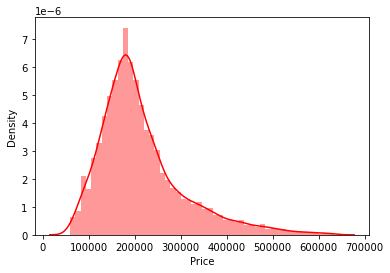

In [16]:
sns.distplot(y, color='r')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Healthcare_1', ylabel='Density'>

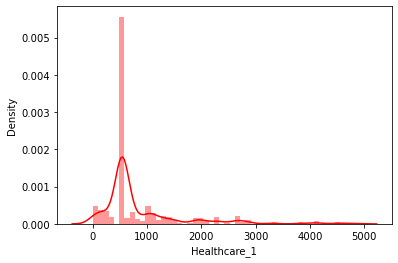

In [17]:
sns.distplot(X['Healthcare_1'], color='r')

In [18]:
X['Healthcare_1'].fillna(X['Healthcare_1'].mean(), inplace=True)

In [19]:
X_test['Healthcare_1'].fillna(X_test['Healthcare_1'].mean(), inplace=True)

In [20]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_test['DistrictId'] = X_test['DistrictId'].astype(str)

## 1.  EDA

In [21]:
X['Rooms_outlier'] = 0  #add column
X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
X.head()        
X.loc[X['Rooms'] == 0, 'Rooms'] = 1
#X.loc[X['Rooms'] >= 6, 'Rooms'] = X['Rooms'].median # !!! медиана посчитана на трейне !!!
#print(X['Rooms'].median)

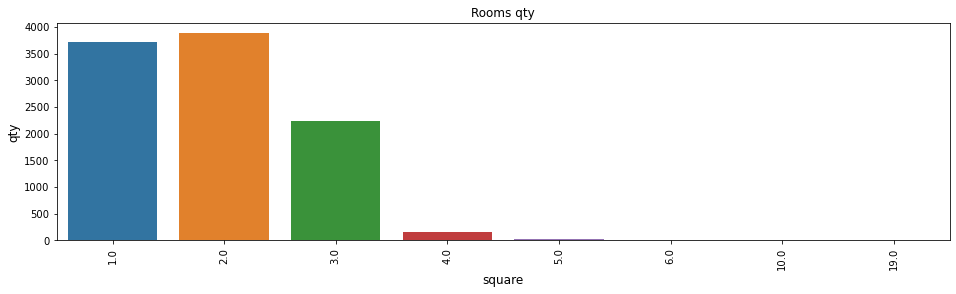

In [22]:
r_qt = (X['Rooms'].value_counts()).reset_index()
r_qt.columns=['Rooms', 'qty']
show_plt(r_qt['Rooms'], r_qt['qty'], 'square', 'qty', 12, (16,4), 90, 'Rooms qty')

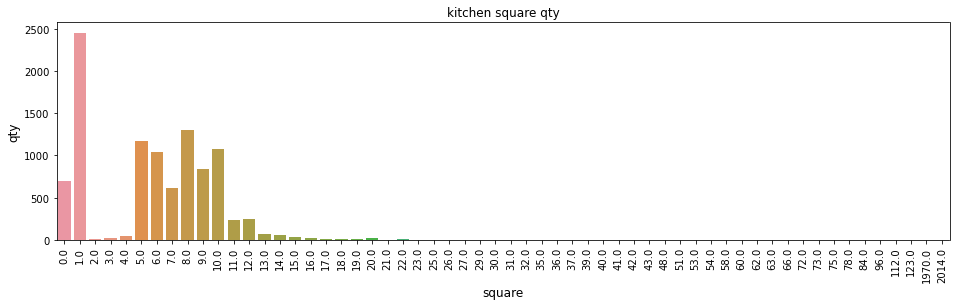

In [23]:
k_sq = (X['KitchenSquare'].value_counts()).reset_index()
k_sq.columns=['square', 'qty']
show_plt(k_sq['square'], k_sq['qty'], 'square', 'qty', 12, (16,4), 90, 'kitchen square qty')

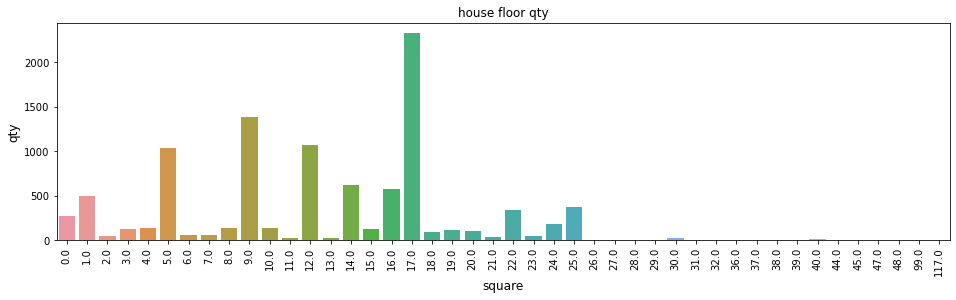

In [24]:
hfl = (X['HouseFloor'].value_counts().sort_values()).reset_index()
hfl.columns=['housefloor', 'qty']
show_plt(hfl['housefloor'], hfl['qty'], 'square', 'qty', 12, (16,4), 90, 'house floor qty')

In [25]:
X[X['HouseFloor'] < X['Floor']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rooms_outlier
Id,,,,,,,,,,,,,,,,,,,
11993,74,2.0,80.312927,33.859653,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,540.0,0,2,B,0
10953,27,1.0,53.769096,52.408028,1.0,5,4.0,1977,0.072158,B,B,2,629,1,540.0,0,0,A,0
2119,27,2.0,49.360649,31.993963,5.0,6,5.0,1983,0.051815,B,B,5,1227,0,540.0,0,0,B,0
11935,27,2.0,64.711838,33.859653,1.0,15,1.0,1977,0.211401,B,B,9,1892,0,540.0,0,1,B,0
6641,54,3.0,118.907608,33.859653,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,52,3.0,64.074974,47.633427,6.0,11,9.0,1983,0.371149,B,B,34,7065,1,750.0,2,5,B,0
16159,27,1.0,38.968338,33.859653,1.0,10,1.0,1977,0.211401,B,B,9,1892,0,540.0,0,1,B,0
4145,96,3.0,90.055229,47.860229,11.0,26,24.0,2005,0.041116,B,B,53,14892,4,540.0,1,4,B,0


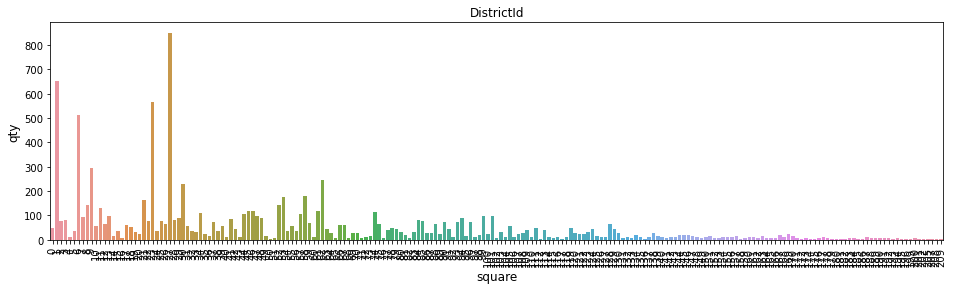

In [26]:
d_id = (X['DistrictId'].value_counts()).reset_index()
d_id.columns=['DistrictId', 'qty']
d_id['DistrictId'] = d_id['DistrictId'].apply(np.int)
show_plt(d_id['DistrictId'], d_id['qty'], 'square', 'qty', 12, (16,4), 90, 'DistrictId')

#d_id.info()
#d_id.sort_values('DistrictId').head(50)

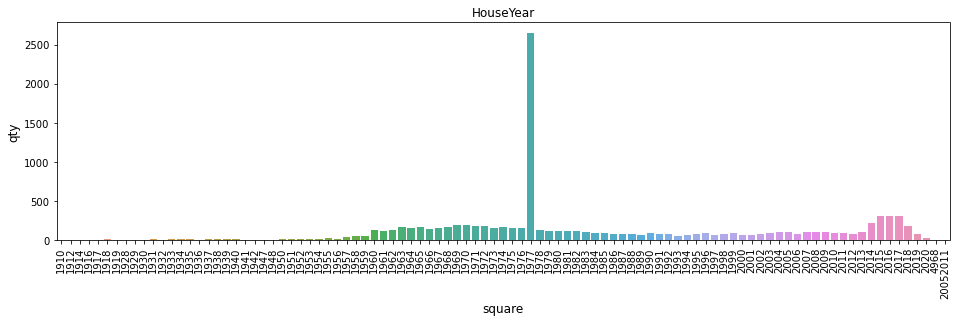

In [27]:
h_y = (X['HouseYear'].value_counts()).reset_index()
h_y.columns=['year', 'qty']
show_plt(h_y['year'], h_y['qty'], 'square', 'qty', 12, (16,4), 90, 'HouseYear')

In [28]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [29]:
X[X['HouseYear'] > 2020].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rooms_outlier
Id,,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,0
11607,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,0


In [30]:
X[X['Square'] > 300]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rooms_outlier
Id,,,,,,,,,,,,,,,,,,,
28,9,2.0,604.705994,33.859653,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,0
2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,0
11602,30,2.0,641.065186,638.163208,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,0


In [31]:
X[X['Square'] < X['LifeSquare']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rooms_outlier
Id,,,,,,,,,,,,,,,,,,,
8054,23,1.0,42.530045,43.967758,1.0,3,9.0,2014,0.034656,B,B,0,168,0,540.0,0,0,B,0
10521,38,3.0,104.211395,106.340401,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,0
2301,1,2.0,61.400055,65.224602,0.0,17,22.0,2016,0.007122,B,B,1,264,0,540.0,0,1,B,0
8753,25,3.0,85.952309,89.803749,1.0,4,3.0,2017,0.069753,B,B,53,13670,4,540.0,1,11,B,0
9870,62,1.0,51.831474,53.491302,1.0,5,1.0,2015,0.072158,B,B,2,629,1,540.0,0,0,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12918,23,2.0,51.440464,53.134243,51.0,3,17.0,2017,0.005767,B,B,1,388,0,540.0,0,0,B,0
2737,27,3.0,123.430069,125.806984,123.0,5,10.0,2015,0.017647,B,B,2,469,0,540.0,0,0,B,0
14001,73,1.0,44.098766,44.267551,1.0,7,24.0,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,0


In [32]:
X[X['Square'] > X['Rooms'] * 100]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rooms_outlier
Id,,,,,,,,,,,,,,,,,,,
9552,23,1.0,105.432182,106.178177,0.0,3,2.0,1977,0.014073,B,B,2,475,0,540.0,0,0,B,0
9275,113,1.0,101.737701,74.881317,16.0,23,24.0,2019,0.050756,B,B,24,5469,1,145.0,0,1,B,0
12638,27,1.0,138.427689,136.215500,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,540.0,0,0,B,1
11055,151,1.0,174.649521,174.837082,15.0,10,12.0,1958,0.236108,B,B,16,3893,27,540.0,3,10,B,0
13603,63,1.0,127.651237,2.609712,1.0,8,17.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,0
15157,54,1.0,106.239624,83.296165,17.0,26,37.0,2009,0.006076,B,B,30,5285,0,645.0,6,6,B,0
7917,27,1.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,540.0,0,1,B,1
11599,23,1.0,121.988052,33.859653,1.0,2,2.0,1977,0.014073,B,B,2,475,0,540.0,0,0,B,0
14662,23,1.0,148.179031,33.859653,1.0,1,2.0,1977,0.014073,B,B,2,475,0,540.0,0,0,B,0


# 2. Data cleaning

In [33]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        X['HouseFloor'] = X['HouseFloor'].apply(np.int)
        X['Rooms'] = X['Rooms'].apply(np.int)
        X['Floor'] = X['Floor'].apply(np.int)
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] # !!! медиана посчитана на трейне !!!
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10  # можно median
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
     #   if 'Healthcare_1' in X.columns:
     #       X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        condition_2 = (X['Square'] < X['LifeSquare'])
        X.loc[condition_2, 'LifeSquare'] = X.loc[condition_2, 'Square'] - X.loc[condition_2, 'KitchenSquare'] - 3
        
        condition_3 = (X['Square'] > 300)
        X.loc[condition_3, 'Square'] = X.loc[condition_3, 'Rooms'] * 30
        X.loc[condition_3, 'LifeSquare'] = X.loc[condition_3, 'Square'] - X.loc[condition_3, 'KitchenSquare']
        
        return X
        

In [34]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_test = imputer.transform(X_test)

# 3. Feature engineering

In [35]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
    #    self.med_price_by_floor_year = None
        self.med_price_by_square = None
    
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
           # df = self.floor_to_cat(df)
          #  df = self.year_to_cat(df)
            df = self.square_to_cat(df)
    
            self.med_price_by_square = df.groupby(['square_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquare'})
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
      #  X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        X = self.square_to_cat(X)
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_square is not None:
            #X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X = X.merge(self.med_price_by_square, on=['square_cat'], how='left')
        
        # добавляем фичу в виде уникального ID здания
        X["BldId"] = X.groupby(["DistrictId", "HouseFloor", "HouseYear", "Ecology_1",
                        "Ecology_2", "Ecology_3", "Social_1", "Social_2", "Social_3", 
                         "Helthcare_2", "Shops_1", "Shops_2"]).ngroup()

        
        return X
    
#    @staticmethod
#    def floor_to_cat(X):
#        X['floor_cat'] = np.nan
#        X.loc[X['Floor'] <= 4, 'floor_cat'] = 0  
#        X.loc[X['Floor'] == 5, 'floor_cat'] = 1
#        X.loc[X['Floor'] >= 6 & (X['Floor'] <= 8), 'floor_cat'] = 2
#        X.loc[X['Floor'] == 9, 'floor_cat'] = 3
#        X.loc[(X['Floor'] >= 10) & (X['Floor'] <= 13), 'floor_cat'] = 4
#        X.loc[(X['Floor'] >= 14) & (X['Floor'] <= 16), 'floor_cat'] = 5
#        X.loc[X['Floor'] == 17, 'floor_cat'] = 6
#        X.loc[(X['Floor'] >= 18) & (X['Floor'] <= 21), 'floor_cat'] = 7
#        X.loc[(X['Floor'] >= 22) & (X['Floor'] <= 25), 'floor_cat'] = 8
#        X.loc[X['Floor'] >= 26, 'floor_cat'] = 9   
#        return X
    
    @staticmethod
    def square_to_cat(X):
        X['square_cat'] = np.nan
        X.loc[X['Square'] < 19, 'square_cat'] = 1
        X.loc[(X['Square'] >= 20) & (X['Square'] <= 49), 'square_cat'] = 2
        X.loc[(X['Square'] >= 50) & (X['Square'] <= 99), 'square_cat'] = 3
        X.loc[(X['Square'] >= 100) & (X['Square'] <= 149), 'square_cat'] = 4
        X.loc[(X['Square'] >= 150) & (X['Square'] <= 199), 'square_cat'] = 5
        X.loc[(X['Square'] >= 200), 'square_cat'] = 6
        return X
    
    @staticmethod
    def year_to_cat(X):
        X['year_cat'] = np.nan
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] >= 1946) & (X['HouseYear'] <= 1976), 'year_cat'] = 3
        X.loc[(X['HouseYear'] == 1977), 'year_cat'] = 4
        X.loc[(X['HouseYear'] >= 1978) & (X['HouseYear'] <= 2000), 'year_cat'] = 5
        X.loc[(X['HouseYear'] >= 2001) & (X['HouseYear'] <= 2013), 'year_cat'] = 6
        X.loc[(X['HouseYear'] >= 2014) & (X['HouseYear'] <= 2018), 'year_cat'] = 7
        X.loc[(X['HouseYear'] >= 2019), 'year_cat'] = 8  
        return X

In [36]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_test = features.transform(X_test)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


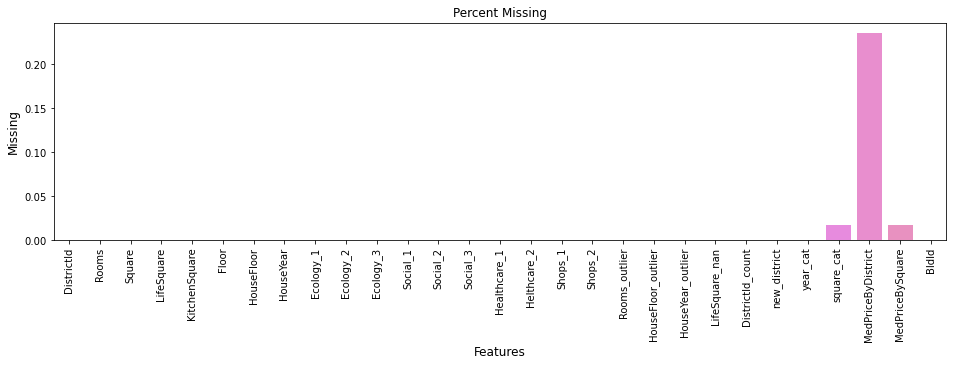

In [37]:
nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [38]:
X.info()
#X['Ecology_2'].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   DistrictId          10000 non-null  object  
 1   Rooms               10000 non-null  float64 
 2   Square              10000 non-null  float32 
 3   LifeSquare          10000 non-null  float32 
 4   KitchenSquare       10000 non-null  float32 
 5   Floor               10000 non-null  float64 
 6   HouseFloor          10000 non-null  float64 
 7   HouseYear           10000 non-null  int32   
 8   Ecology_1           10000 non-null  float32 
 9   Ecology_2           10000 non-null  category
 10  Ecology_3           10000 non-null  category
 11  Social_1            10000 non-null  int8    
 12  Social_2            10000 non-null  int16   
 13  Social_3            10000 non-null  int16   
 14  Healthcare_1        10000 non-null  float32 
 15  Helthcare_2         10000 non-null  i

In [39]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DistrictId          5000 non-null   object 
 1   Rooms               5000 non-null   float64
 2   Square              5000 non-null   float64
 3   LifeSquare          5000 non-null   float64
 4   KitchenSquare       5000 non-null   float64
 5   Floor               5000 non-null   float64
 6   HouseFloor          5000 non-null   float64
 7   HouseYear           5000 non-null   int64  
 8   Ecology_1           5000 non-null   float64
 9   Ecology_2           5000 non-null   int64  
 10  Ecology_3           5000 non-null   int64  
 11  Social_1            5000 non-null   int64  
 12  Social_2            5000 non-null   int64  
 13  Social_3            5000 non-null   int64  
 14  Healthcare_1        5000 non-null   float64
 15  Helthcare_2         5000 non-null   int64  
 16  Shops_

In [40]:
cat_columns = df.select_dtypes(['category']).columns

cat_columns
X[cat_columns] = X[cat_columns].apply(lambda c: c.cat.codes)

In [41]:
remain_features = [#'Rooms', 
                   'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                  # 'Rooms_outlier',
                  # 'HouseFloor_outlier', #'HouseYear_outlier', 
                  # 'LifeSquare_nan',
                   'HouseFloor', 'HouseYear','BldId',# 'Ecology_2',
                   'DistrictId_count', #'new_district', 'Ecology_3',
                  # 'Shops_2',
                   'MedPriceByDistrict',
                 #  'MedPriceByFloorYear'
                   'MedPriceBySquare'
                  ]

X = X[remain_features]
X_test = X_test[remain_features]

In [42]:
X_num_features = X.dtypes[X.dtypes != 'object'].index
X_cat_features = X.dtypes[X.dtypes == 'object'].index

print(f'qty of num features: {len(X_num_features)}')
print(X[X_num_features].columns)
print()
print(f'qty of cat features: {len(X_cat_features)}')
print(X[X_cat_features].columns)

qty of num features: 13
Index(['Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1',
       'Social_1', 'Shops_1', 'HouseFloor', 'HouseYear', 'BldId',
       'DistrictId_count', 'MedPriceByDistrict', 'MedPriceBySquare'],
      dtype='object')

qty of cat features: 0
Index([], dtype='object')


In [43]:
X_test_num_features = X_test.dtypes[X_test.dtypes != 'object'].index
X_test_cat_features = X_test.dtypes[X_test.dtypes == 'object'].index

print(f'qty of num features: {len(X_test_num_features)}')
print(X_test[X_test_num_features].columns)
print()
print(f'qty of cat features: {len(X_test_cat_features)}')
print(X_test[X_test_cat_features].columns)

qty of num features: 13
Index(['Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1',
       'Social_1', 'Shops_1', 'HouseFloor', 'HouseYear', 'BldId',
       'DistrictId_count', 'MedPriceByDistrict', 'MedPriceBySquare'],
      dtype='object')

qty of cat features: 0
Index([], dtype='object')


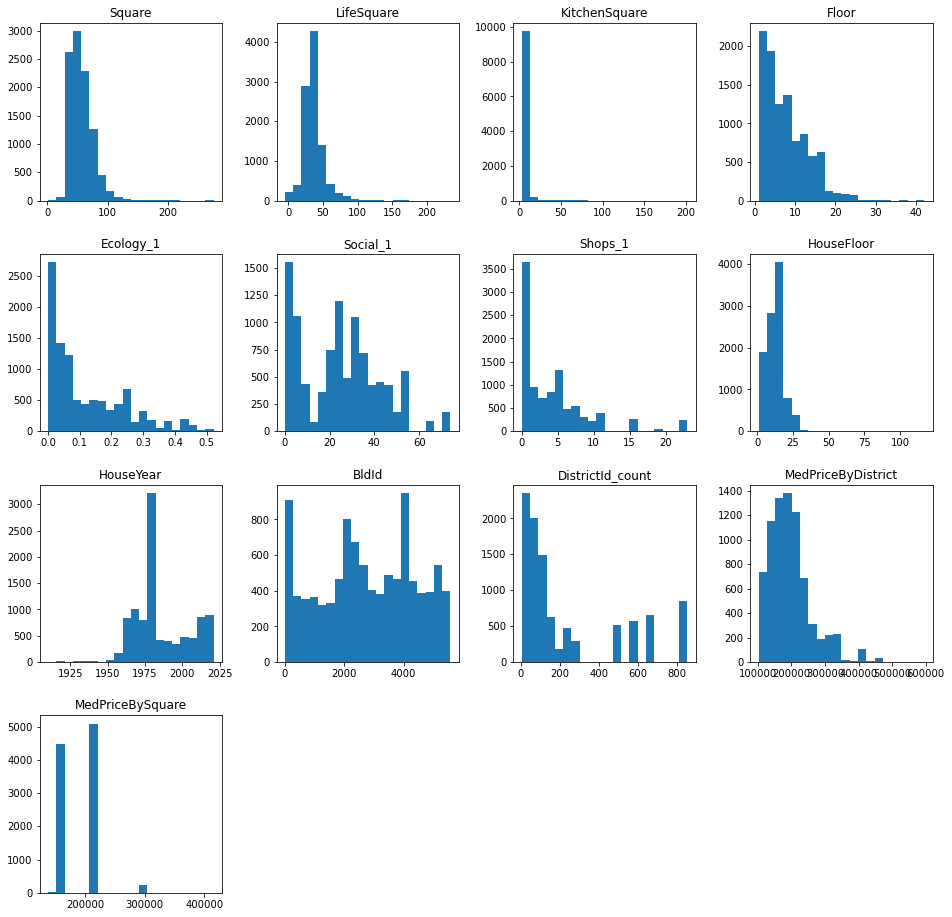

In [44]:
df_num_features = X.copy()
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Square              10000 non-null  float32
 1   LifeSquare          10000 non-null  float32
 2   KitchenSquare       10000 non-null  float32
 3   Floor               10000 non-null  float64
 4   Ecology_1           10000 non-null  float32
 5   Social_1            10000 non-null  int8   
 6   Shops_1             10000 non-null  int8   
 7   HouseFloor          10000 non-null  float64
 8   HouseYear           10000 non-null  int32  
 9   BldId               10000 non-null  int64  
 10  DistrictId_count    10000 non-null  float64
 11  MedPriceByDistrict  7646 non-null   float32
 12  MedPriceBySquare    9831 non-null   float32
dtypes: float32(6), float64(3), int32(1), int64(1), int8(2)
memory usage: 683.6 KB


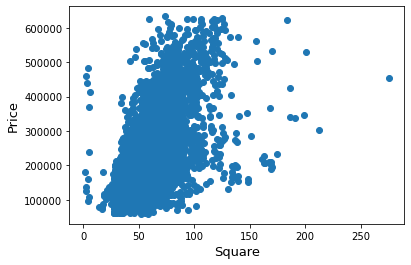

In [46]:
fix, ax = plt.subplots()
ax.scatter(x=X['Square'], y=y)
plt.ylabel('Price', fontsize=13)
plt.xlabel('Square', fontsize=13)
plt.show()

In [47]:
#sc = StandardScaler()
#all_X_sc = sc.fit_transform(X)
#X = pd.DataFrame(all_X_sc)
X.head()

,Square,LifeSquare,KitchenSquare,Floor,Ecology_1,Social_1,Shops_1,HouseFloor,HouseYear,BldId,DistrictId_count,MedPriceByDistrict,MedPriceBySquare
0,47.981560,29.442751,6.0,7.0,0.089040,33,11,9.0,1969,2918,5.0,NaN,156041.9375
1,65.683640,40.049541,8.0,7.0,0.000070,46,16,9.0,1978,3108,87.0,300009.437500,215881.3750
2,44.947952,29.197611,3.0,8.0,0.049637,34,3,12.0,1968,3667,174.0,263206.218750,156041.9375
3,53.352982,52.731510,9.0,8.0,0.437885,23,5,17.0,1977,3957,179.0,166809.671875,215881.3750
4,39.649193,23.776169,7.0,11.0,0.012339,35,4,12.0,1976,5550,97.0,158539.062500,156041.9375


In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Square              10000 non-null  float32
 1   LifeSquare          10000 non-null  float32
 2   KitchenSquare       10000 non-null  float32
 3   Floor               10000 non-null  float64
 4   Ecology_1           10000 non-null  float32
 5   Social_1            10000 non-null  int8   
 6   Shops_1             10000 non-null  int8   
 7   HouseFloor          10000 non-null  float64
 8   HouseYear           10000 non-null  int32  
 9   BldId               10000 non-null  int64  
 10  DistrictId_count    10000 non-null  float64
 11  MedPriceByDistrict  7646 non-null   float32
 12  MedPriceBySquare    9831 non-null   float32
dtypes: float32(6), float64(3), int32(1), int64(1), int8(2)
memory usage: 683.6 KB


In [59]:
X_test.to_csv('repp_test_transformed.csv', index=False)

In [60]:
y_test

NameError: name 'y_test' is not defined

# 4. Model & prediction

In [55]:
continuous_columns = remain_features
final_transformers = list()
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [49]:
%%time

model = CatBoostRegressor(depth=2, 
                          learning_rate=0.1, 
                          n_estimators=300,
                          loss_function='RMSE',
                          custom_metric='R2',
                          random_seed=42,
                          silent=True
                         )

model.fit(X, y, plot=True, verbose=False)

cv_score = cross_val_score(
    model,
    X,
    y,
    scoring='r2',
    cv=KFold(
            n_splits=5,
            shuffle=True,
            random_state=42
    )
)

print(f'R2: {round(cv_score.mean(), 3)}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

R2: 0.701
CPU times: user 5.43 s, sys: 734 ms, total: 6.16 s
Wall time: 2.92 s


In [50]:
%%time

lgbm_model = LGBMRegressor(max_depth=7,
                      #       min_samples_leaf=10,
                             n_estimators=300,
                             random_state=42,
                     num_leaves=30)

cv_score = cross_val_score(
    lgbm_model,
    X,
    y,
    scoring='r2',
    cv=KFold(
            n_splits=5,
            shuffle=True,
            random_state=42
    )
)

print(f'R2: {round(cv_score.mean(), 3)}')

R2: 0.74
CPU times: user 14.3 s, sys: 747 ms, total: 15.1 s
Wall time: 2.8 s


In [51]:
%%time

final_model = CatBoostRegressor(
    silent=True,
    learning_rate=0.1,
    iterations=1150,
    eval_metric='R2',
    depth=8
)

final_model.fit(X, y, plot=True)

cv_score = cross_val_score(
    final_model,
    X,
    y,
    scoring='r2',
    cv=KFold(
            n_splits=5,
            shuffle=True,
            random_state=42
    )
)

print(f'R2: {round(cv_score.mean(), 3)}')

y_pred_test = final_model.predict(X_test)

preds_test['Price'] = y_pred_test
preds_test.to_csv('repp_predictions.csv', index=False)

preds_test.head()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

R2: 0.744
CPU times: user 1min 57s, sys: 7.25 s, total: 2min 5s
Wall time: 32 s


,Id,Price
0,725,146965.594387
1,15856,252022.361965
2,5480,212766.709224
3,15664,318776.389827
4,14275,156897.975689


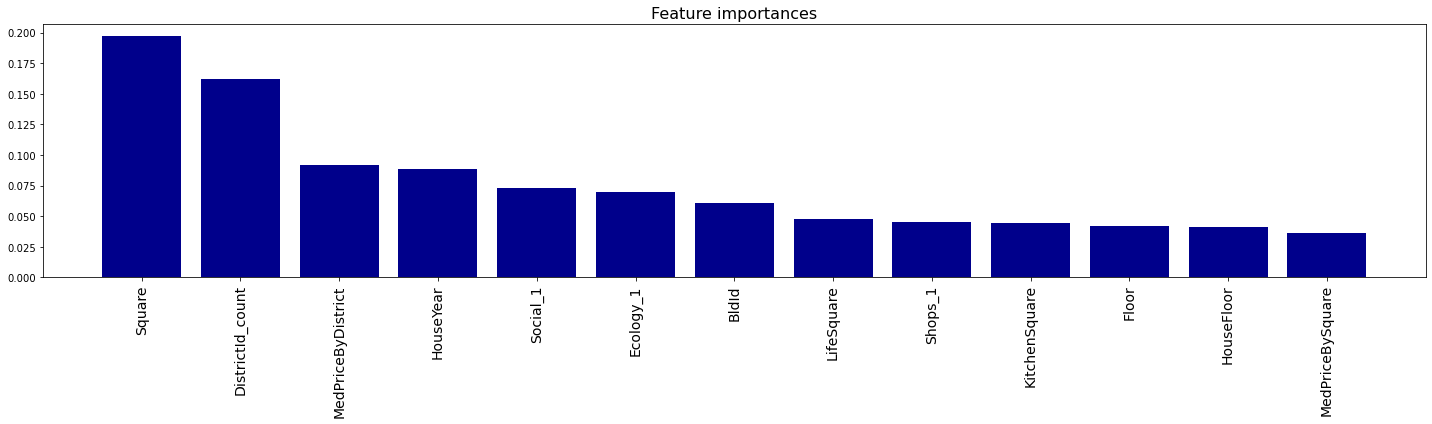

In [52]:
plot_feature_importances(importances = final_model.feature_importances_, X=X)

In [56]:
pipeline_model = Pipeline([
    ('features',feats),
    ('regressor', CatBoostRegressor(
                                    silent=True,
                                    learning_rate=0.1,
                                    iterations=1150,
                                    eval_metric='R2',
                                    depth=8
                                    )),
                        ])

#обучим наш пайплайн
pipeline_model.fit(X, y)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Square',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Square')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('LifeSquare',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='LifeSquare')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('KitchenSquare',
                                                 Pipeline(steps=[('selector',
                       

In [58]:
with open("repp_model.dill", "wb") as f:
    dill.dump(pipeline_model, f)